# CaloriePhone: food-to-calorie translation

TODO description

### Import libraries


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

import getpass

2022-06-05 16:17:59.936702: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
tf.__version__
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-06-05 16:18:02.650190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:18:02.653922: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:18:02.654013: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


We will be using `InceptionResNetV2` as out base model for transfer learning (this will be explained later in-depth). For now, we define the `IMG_SIZE` to be 299x299, the resolution this model expects.

In [3]:
# InceptionResNetV2 accepts 299x299 images as input
IMG_SIZE = (299, 299)
IMG_SHAPE = IMG_SIZE + (3,)
BATCH_SIZE = 32
MOUNT_PATH = '/mnt/drive'
DATA_DIR = '/mnt/drive/MyDrive/caloriephone/data'

# mount drive
from google.colab import drive
drive.mount(MOUNT_PATH)

### Data Preprocessing


Besides building the classificator, we need to know how many calories each kind of food contains. We will be using the `vaishnavivenkatesan/food-and-their-calories` dataset which is a CSV file of different foods and the appropriate amount of calories in a single serving of each.

In [4]:
# we will need to download the mapping from kaggle datasets
# let's make sure kaggle cli is installed
!python3 -m pip install kaggle

# get log-in credentials
# get credentials from https://www.kaggle.com -> click on your username on the right -> "Account" in the middle bar -> "Create New API Token" 
os.environ["KAGGLE_USERNAME"] = input("Kaggle username: ")
os.environ["KAGGLE_KEY"] = getpass.getpass("Kaggle key: " )

# download mapping
!kaggle datasets download --unzip vaishnavivenkatesan/food-and-their-calories

  0%|                                               | 0.00/6.59k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.59k/6.59k [00:00<00:00, 5.64MB/s]


In [4]:
# read food to calorie mapping CSV
mapping_csv = pd.read_csv("Food and Calories - Sheet1.csv")
mapping_csv.head()

,Food,Serving,Calories
0,Artichoke,1 artichoke (128 g),60 cal
1,Arugula,1 leaf (2 g),1 cal
2,Asparagus,1 spear (12 g),2 cal
3,Aubergine,1 aubergine (458 g),115 cal
4,Beetroot,1 beet (82 g),35 cal


Let's see how many food types there are in this CSV:

In [5]:
# each food type is a row
# thus amount of rows is indicative of the amount of possible classes
print(mapping_csv.shape[0])

562


For some reason, the provided CSV contains duplicates of some foods. Let's filter them out.

In [6]:
mapping_csv.drop_duplicates(subset=['Food'], inplace=True)
print(mapping_csv.shape[0])

541


Some of the classes found in this CSV are extremely specific. They include classes such as:

- Big N' Tasty (commercial name for a McDonald's burger)
- Burger King Angry Whopper (also a commercial name, not an actual food type)
- Alphabet Soup	(a soup that has letter shaped pasta in it)

We aim to classify different food types, as opposed to specific foods, so we have decided to filter out some of the classes.

In [7]:
# define a blacklist of foods
food_class_blacklist = [
  "Acerola",
  "Almond Oil",
  "Alphabet Soup",
  "Amaranth",
  "Applesauce",
  "Apricot Kernel Oil",
  "Arby’s Grand Turkey Club",
  "Arby’s Reuben",
  "Arby’s Roast Beef Classic",
  "Arby’s Roast Beef Max",
  "Argan Oil",
  "Asian Pear",
  "Avocado Oil",
  "BBQ Chicken Pizza",
  "BBQ Pizza",
  "BBQ Rib",
  "BBQ Ribs",
  "BLT",
  "Babassu Oil",
  "Baby Back Ribs",
  "Bacon and Eggs",
  "Baked Beans",
  "Barley",
  "Barley Groats",
  "Baskin-Robbins",
  "Bean Burrito",
  "Bean Stew",
  "Beef Bouillon",
  "Beef Noodle Soup",
  "Beef Pizza",
  "Beef Soup",
  "Beef Stew",
  "Beetroot",
  "Bell Pepper",
  "Ben and Jerry’s",
  "Bianca Pizza",
  "Big N’ Tasty",
  "Biryani",
  "Black Olives",
  "Black Pudding",
  "Black Rice",
  "Blood Oranges",
  "Bouillon",
  "Bratwurst",
  "Breadfruit",
  "Broccoli Cheese Soup",
  "Broccoli Soup",
  "Brown Rice",
  "Brussels Sprouts",
  "Buckwheat",
  "Buckwheat Groats",
  "Buffalo Chicken Pizza",
  "Burger King Angry Whopper",
  "Burger King Double Whopper",
  "Burger King Double Whopper with Cheese",
  "Burger King Original Chicken Sandwich",
  "Burger King Premium Alaskan Fish Sandwich",
  "Burger King Triple Whopper",
  "Burger King Whopper",
  "Burger King Whopper Jr.",
  "Burger King Whopper with Cheese",
  "Butter Chicken",
  "Butter Pecan Ice Cream",
  "Cabbage Soup",
  "Calabrese Pizza",
  "California Roll",
  "Calzone",
  "Cannelloni",
  "Canola Oil",
  "Cantaloupe",
  "Cantaloupe Melon",
  "Capellini",
  "Cappelletti",
  "Capricciosa Pizza",
  "Capsicum",
  "Carrot Ginger Soup",
  "Carrot Soup",
  "Carvel",
  "Casaba Melon",
  "Cellophane Noodles",
  "Chard",
  "Cheese Pizza",
  "Cheese Tortellini",
  "Cheeseburger",
  "Cherimoya",
  "Cherry Tomato",
  "Chicken Bouillon",
  "Chicken Breast",
  "Chicken Broth",
  "Chicken Caesar Salad",
  "Chicken Fajita",
  "Chicken Fried Steak",
  "Chicken Gumbo Soup",
  "Chicken Marsala",
  "Chicken McNuggets",
  "Chicken Noodle Soup",
  "Chicken Nuggets",
  "Chicken Parmesan",
  "Chicken Pizza",
  "Chicken Pizziola",
  "Chicken Pot Pie",
  "Chicken Sandwich",
  "Chicken Stock",
  "Chicken Teriyaki Sandwich",
  "Chicken Tikka Masala",
  "Chicken Vegetable Soup",
  "Chicken Wings",
  "Chicken with Rice Soup",
  "Chicory",
  "Chili con Carne",
  "Chimichanga",
  "Chinese Cabbage",
  "Chocolate Chip Ice Cream",
  "Chocolate Ice Cream",
  "Chop Suey",
  "Ciao Bella",
  "Cobb Salad",
  "Coconut Oil",
  "Coffee Ice Cream",
  "Cold Stone Creamery",
  "Collard Greens",
  "Cookie Dough Ice Cream",
  "Corn Dog",
  "Corn Oil",
  "Corn Waffles",
  "Corned Beef Hash",
  "Cornmeal",
  "Cornstarch",
  "Cottage Pie",
  "Cottonseed Oil",
  "Courgette",
  "Couscous",
  "Cream of Asparagus Soup",
  "Cream of Broccoli Soup",
  "Cream of Celery Soup",
  "Cream of Chicken Soup",
  "Cream of Mushroom Soup",
  "Cream of Onion Soup",
  "Cream of Potato Soup",
  "Creamed Spinach",
  "Creamy Chicken Noodle Soup",
  "Crunchie McFlurry",
  "Curly Fries",
  "Custard Apple",
  "Dairy Milk McFlurry",
  "Dal",
  "Dampfnudel",
  "Deep Dish Pizza",
  "Deviled Eggs",
  "Dim Sum",
  "Dippin Dots",
  "Dominos Philly Cheese Steak Pizza",
  "Dosa",
  "Double Cheeseburger",
  "Double Rainbow",
  "Dragon Fruit",
  "Drumsticks",
  "Dumpling Dough",
  "Durian",
  "Durum Wheat Semolina",
  "Egg Noodles",
  "Egg Roll",
  "Enchiladas",
  "Endive",
  "Fajita",
  "Farfalle",
  "Feijoa",
  "Fennel",
  "Fettuccine",
  "Filet-o-Fish",
  "Fish Sandwich",
  "Fish and Chips",
  "Flaxseed",
  "Flaxseed Oil",
  "Four Cheese Pizza",
  "Freekeh",
  "French Fries",
  "French Onion Soup",
  "French Vanilla Ice Cream",
  "Fried Rice",
  "Fried Shrimp",
  "Friendly’s",
  "Fruit salad",
  "Fusilli",
  "Galia Melon",
  "Glass Noodles",
  "Goat Cheese Pizza",
  "Golden Mushroom Soup",
  "Goulash",
  "Grape Seed Oil",
  "Green Beans",
  "Green Olives",
  "Green Onion",
  "Greengage",
  "Grilled Cheese Sandwich",
  "Grilled Chicken Salad",
  "Grilled Pizza",
  "Grissini",
  "Ham Sandwich",
  "Ham and Cheese Sandwich",
  "Hawaiian Pizza",
  "Hazelnut Oil",
  "Healthy Choice",
  "Horseradish",
  "Hot Dog",
  "Hot Fudge Sundae",
  "Ice Cream Sandwich",
  "Ice Cream Sundae",
  "Ice Milk",
  "Instant Ramen",
  "Italian BMT",
  "Jambalaya",
  "Jujube",
  "Kamut",
  "Kohlrabi",
  "Kumara",
  "Kumquat",
  "Lasagne",
  "Lasagne Sheets",
  "Lentil Soup",
  "Linguine",
  "Linseed Oil",
  "Lobster Bisque Soup",
  "Low Carb Pasta",
  "Lychee",
  "Lychees",
  "Mac and Cheese",
  "Macaroni and Cheese",
  "Magnolia",
  "Magnum",
  "Magnum Almond",
  "Magnum Double Caramel",
  "Magnum Double Chocolate",
  "Magnum Gold",
  "Magnum White",
  "Mandarin Oranges",
  "Mangosteen",
  "Manicotti",
  "Maracuya",
  "Maraschino Cherries",
  "Margherita Pizza",
  "Mashed Potatoes",
  "McDonald’s Big Mac",
  "McDonald’s Cheeseburger",
  "McDonald’s Chicken Nuggets",
  "McDonald’s Double Cheeseburger",
  "McDonald’s Filet-o-Fish",
  "McDonald’s McChicken",
  "McDonald’s McDouble",
  "McDonald’s McMuffi Egg",
  "McDonald’s McRib",
  "McDonald’s Mighty Wings",
  "McFlurry",
  "McFlurry Oreo",
  "McRib",
  "Meat Pie",
  "Meatball Sandwich",
  "Meatball Soup",
  "Meatloaf",
  "Menhaden Oil",
  "Millet",
  "Millet Flour",
  "Millet Gruel",
  "Minestrone",
  "Mini Milk",
  "Minneola",
  "Mint Chocolate Chip Ice Cream",
  "Mostaccioli",
  "Mozzarella Pizza",
  "Mushroom Pizza",
  "Mushroom Soup",
  "Muskmelon",
  "Mustard Greens",
  "Mustard Oil",
  "Naan",
  "Nachos with Cheese",
  "Napoli Pizza",
  "New York Style Pizza",
  "Noni",
  "Noodle Soup",
  "Nori",
  "Oat Bran",
  "Oat Oil",
  "Okra",
  "Olive Oil",
  "Onion Rings",
  "Onion Soup",
  "Orange Chicken",
  "Orecchiette",
  "Orzo",
  "Oxtail Soup",
  "Pad Thai",
  "Palm Kernel Oil",
  "Palm Oil",
  "Paratha",
  "Parsnips",
  "Passion Fruit",
  "Pea Soup",
  "Peanut Butter Sandwich",
  "Peanut Oil",
  "Pearl Barley",
  "Peking Duck",
  "Penne Rigate",
  "Pepperoni Pizza",
  "Philly Cheese Steak",
  "Physalis",
  "Pierogi",
  "Pink Grapefruit",
  "Pizza Dough",
  "Pizza Hut Stuffed Crust Pizza",
  "Pizza Hut Supreme Pizza",
  "Pizza Rolls",
  "Plantain",
  "Plantains",
  "Polenta",
  "Poppy Seed Oil",
  "Pork Chop",
  "Potato Salad",
  "Potato Soup",
  "Poutine",
  "Prawn Crackers",
  "Pretzel Sticks",
  "Prickly Pear",
  "Pulled Pork Sandwich",
  "Pumpkin Seed Oil",
  "Pumpkin Soup",
  "Quattro Formaggi Pizza",
  "Radishes",
  "Rambutan",
  "Red Cabbage",
  "Red Pepper Pizza",
  "Reuben Sandwich",
  "Rice Bran Oil",
  "Rigatoni",
  "Roast Beef",
  "Roast Dinner",
  "Rocky Road Ice Cream",
  "Rotini",
  "Rusk",
  "Rutabaga",
  "Rye Bran",
  "Safflower Oil",
  "Sago",
  "Salami Pizza",
  "Salmon Oil",
  "Samosa",
  "Sapodilla",
  "Sausage Pizza",
  "Sausage Roll",
  "Sausage Rolls",
  "Savoury Biscuits",
  "Schwan’s",
  "Scotch Broth",
  "Seafood Pizza",
  "Sesame Oil",
  "Shea Oil",
  "Shepherds Pie",
  "Shirataki Noodles",
  "Shortbread",
  "Shrimp Cocktail",
  "Shrimp Pizza",
  "Sicilian Pizza",
  "Sloppy Joe",
  "Sloppy Joes",
  "Smarties McFlurry",
  "Smoked Salmon",
  "Snickers Ice Cream",
  "Soft Serve",
  "Solero",
  "Soursop Fruit",
  "Soy Noodles",
  "Soy Oil",
  "Spaetzle",
  "Spaghetti Bolognese",
  "Spelt",
  "Spelt Bran",
  "Spelt Semolina",
  "Spicy Italian",
  "Spinach Feta Pizza",
  "Spinach Pizza",
  "Spinach Tortellini",
  "Spirelli",
  "Spring Roll",
  "Spring Rolls",
  "Star Fruit",
  "Starfruit",
  "Strawberry Ice Cream",
  "Strawberry Sundae",
  "Stuffed Crust Pizza",
  "Subway Club Sandwich",
  "Succotash",
  "Sunflower Oil",
  "Sunflower Seeds",
  "Sweet Potato",
  "Tagliatelle",
  "Tandoori Chicken",
  "Tarte Flambée",
  "Thai Soup",
  "Thin Crust Pizza",
  "Tomato Rice Soup",
  "Tomato Seed Oil",
  "Tomato Soup",
  "Tortilla Chips",
  "Tortilla Wrap",
  "Tuna Pizza",
  "Turkey Hill",
  "Turnip Greens",
  "Vanilla Cone",
  "Vanilla Ice Cream",
  "Vegetable Beef Soup",
  "Vegetable Broth",
  "Vegetable Oil",
  "Vegetable Pizza",
  "Vegetable Soup",
  "Vegetable Stock",
  "Vegetarian Pizza",
  "Veggie Burger",
  "Veggie Delight",
  "Veggie Patty",
  "Veggie Pizza",
  "Walnut Oil",
  "Wedding Soup",
  "Wendy’s Baconator",
  "Wendy’s Jr. Bacon Cheeseburger",
  "Wendy’s Jr. Cheeseburger",
  "Wendy’s Son of Baconator",
  "Wheat Bran",
  "Wheat Germ",
  "Wheat Germ Oil",
  "Wheat Gluten",
  "Wheat Semolina",
  "Wheat Starch",
  "White Pizza",
  "Whole Grain Noodles",
  "Whole Grain Spaghetti",
  "Whole Grain Wheat",
  "Wholegrain Oat",
  "Whopper",
  "Winter Squash",
  "Yorkshire Pudding",
  "Zinger",
  "Zinger Burger",
  "Ziti"
]

# filter CSV
mapping_csv.drop(mapping_csv[mapping_csv["Food"].isin(food_class_blacklist)].index, inplace=True)

Let's see the amount of classes we are left with:

In [8]:
# each food type is a row
# thus amount of rows is indicative of the amount of possible classes
CLASSES_AMOUNT = mapping_csv.shape[0]
print(CLASSES_AMOUNT)

98


Now that we have the filtered CSV we need, we can start downloading our data. The following automation queries Unsplash image search API for images and stores them in appropriate train and test directories.

The initial run of the script will take a while because of bandwidth, latency and rate limiting issues.

- a free Unsplash account is allowed to query search API 50 times an hour - meaning 50 searches, each one with 30 results (images). So:
  - in an hour, we can only download 30 * 50 = 1500 images
  - given that we are dealing with 322 classes with 90 images per class (worst case), (322 * 90) / (30 * 50) = ~19 hours in total
- if the notebook is being executed on a local machine, the bandwidth + latency issues come into play. These can be solved by running the script through Google Colab since a virtual machine is being provisioned for execution which is located in a data center. Chances are, this virtual machine is much closer to Unsplash servers than we are. 

The script skips download of a class if a directory for that class is already present, therefore a second run barely takes time since it does not query the API or download anything.

In [10]:
import logging
import time
import requests
import json
import urllib.request
import shutil

RATE_LIMIT_TIMEOUT_SECONDS = 3720
IMAGE_FORMAT = "jpg"
PAGES_PER_CLASS = 3 # each page gets you 30 images
TEST_SPLIT = 0.2

def query_unsplash_api(url, params, client_id):

    logging.info(f"qeurying API at {url} with params {params} ...")

    rate_limit_reached = False
    response_received = False

    # query api until a response is received
    while not response_received:

      try:

          # query api
          response = requests.get(url, params=params, timeout=60, headers={
              "Accept-Version": "v1",
              "Authorization": f"Client-ID {client_id}"
          })
          response.raise_for_status()

      except requests.HTTPError as e:

          # 403 - rate limit reached
          if e.response.status_code == 403:
            rate_limit_reached = True
          else:
            raise e

      # if HTTP status code is valid - response received
      else:
          response_received = True

      # handle rate limit reached
      if rate_limit_reached or ( response_received and int(response.headers["X-Ratelimit-Remaining"]) == 0 ):
          logging.info(f"rate limit reached, sleeping for {RATE_LIMIT_TIMEOUT_SECONDS} seconds...")
          time.sleep(RATE_LIMIT_TIMEOUT_SECONDS)

    # log remaining rate limit
    logging.info(f"X-Ratelimit-Remaining: {response.headers['X-Ratelimit-Remaining']}")

    return response

def main():

    # parse arguments
    CLIENT_ID = getpass.getpass("unsplash.com client ID: ")

    # set-up logger
    logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(message)s')

    # for each food
    for _, row in mapping_csv.iterrows():

        # get food and serving fields
        food = row['Food'].strip()
        food_train_path = f"{DATA_DIR}/train/{food}"
        food_test_path = f"{DATA_DIR}/test/{food}"

        # download images only if directory is not yet present
        if os.path.exists(food_train_path):
            
            logging.info(f"'{food_train_path}' already exists, skipping")

        else:

            # initiate food train directory
            os.makedirs(food_train_path)

            # init downloaded image list
            image_names = []

            # iterate result pages
            for page_index in range(PAGES_PER_CLASS):

              # query api for images
              search_response = json.loads(query_unsplash_api("https://api.unsplash.com/search/photos", params={
                  "query": f"{food}",
                  "page": f"{page_index + 1}",
                  "per_page": "30"
              }, client_id=CLIENT_ID).text)

              # iterate search results
              for image in search_response["results"]:

                  # download image
                  image_url = f'{image["urls"]["raw"]}&crop=entropy&w={IMG_SIZE[0]}&h={IMG_SIZE[1]}&fm={IMAGE_FORMAT}'
                  image_path = f"{food_train_path}/{image['id']}.{IMAGE_FORMAT}"
                  logging.info(f"downloading image for '{food}' at {image_url} ...")
                  urllib.request.urlretrieve(image_url, image_path)
                  image_names.append(os.path.basename(image_path))

            # clear food test directory
            if os.path.exists(food_test_path):
              shutil.rmtree(food_test_path)
            os.makedirs(food_test_path)

            # iterate test split
            for image_name_index in range(int(len(image_names) * TEST_SPLIT)):

              # move image to test set
              image_src_path = f"{food_train_path}/{image_names[image_name_index]}"
              image_dst_path = f"{food_test_path}/{image_names[image_name_index]}"
              logging.info(f"moving '{food}' image at {image_src_path} to {image_dst_path}")
              os.rename(image_src_path, image_dst_path)            

if __name__ == "__main__":
    main()


[2022-06-05 09:55:12,775] '/home/vlad/Downloads/test/data/train/Artichoke' already exists, skipping
[2022-06-05 09:55:12,776] '/home/vlad/Downloads/test/data/train/Arugula' already exists, skipping
[2022-06-05 09:55:12,777] '/home/vlad/Downloads/test/data/train/Asparagus' already exists, skipping
[2022-06-05 09:55:12,779] '/home/vlad/Downloads/test/data/train/Aubergine' already exists, skipping
[2022-06-05 09:55:12,780] '/home/vlad/Downloads/test/data/train/Broccoli' already exists, skipping
[2022-06-05 09:55:12,781] '/home/vlad/Downloads/test/data/train/Cabbage' already exists, skipping
[2022-06-05 09:55:12,783] '/home/vlad/Downloads/test/data/train/Carrot' already exists, skipping
[2022-06-05 09:55:12,783] '/home/vlad/Downloads/test/data/train/Cauliflower' already exists, skipping
[2022-06-05 09:55:12,784] '/home/vlad/Downloads/test/data/train/Celery' already exists, skipping
[2022-06-05 09:55:12,785] '/home/vlad/Downloads/test/data/train/Chives' already exists, skipping
[2022-06-05 

Now that the data is present - we can load our training, validation and testing sets and begin construction of our network!

In [9]:
# read entire dataset and split to train, validation and test sets
training_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/train",
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode='categorical',
                                                            validation_split=0.2,
                                                            seed=42,
                                                            subset='training')

validation_set = tf.keras.utils.image_dataset_from_directory(   f"{DATA_DIR}/train",
                                                                shuffle=True,
                                                                batch_size=BATCH_SIZE,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                validation_split=0.2,
                                                                seed=42,
                                                                subset='validation')

test_set = tf.keras.utils.image_dataset_from_directory( f"{DATA_DIR}/test",
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE,
                                                        label_mode='categorical')

Found 6322 files belonging to 98 classes.
Using 5058 files for training.


2022-06-05 16:20:23.873959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-05 16:20:23.874587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:20:23.874736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-05 16:20:23.874836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

Found 6322 files belonging to 98 classes.
Using 1264 files for validation.
Found 1659 files belonging to 98 classes.


The code below will enable buffer prefetching or all sets. This setting will let images load from disk without encountering I/O blocking, making the data streaming process faster.

In [10]:
training_set = training_set.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_set = validation_set.prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the CNN

We will use transfer learning, a technique which uses a pre-trained model, to achieve good results. The model we are going to use is called `InceptionResNetV2`, which has proven itself to work very well with classification in our previous exercises.

In [11]:
# use InceptionResNet2 as base model
base_model_function = tf.keras.applications.InceptionResNetV2
base_model_preprocess_input = tf.keras.applications.inception_resnet_v2.preprocess_input
base_model_decode_predictions = tf.keras.applications.inception_resnet_v2.decode_predictions

In [12]:
# init base model
base_model = base_model_function(   input_shape=IMG_SHAPE,
                                    include_top=False,
                                    weights='imagenet')

# freeze base layers
base_model.trainable = False

Data augmentation is a good idea in our case for the following reasons:
- food can be pictured from a variety of angles
- we are dealing with a relatively small dataset

In [15]:
# init base layer with augmentations
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Here's a preview of how this augmentation affects our images: 

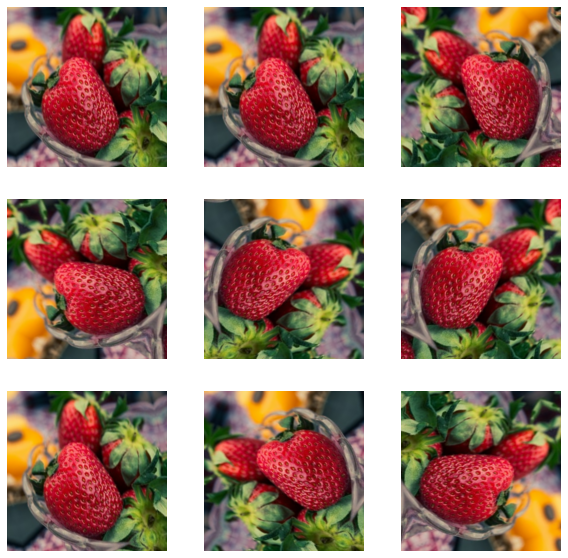

In [25]:
for image, _ in training_set.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

After passing an image through our base model, we will need to generate predictions from returned block of features. This `GlobalAveragePooling2D` layer will convert these features to a single vector.

In [18]:
# convert to vectors for feature extraction 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Finally, the prediction layer is needed for our model's output. Each unit in this `Dense` layer accounts for a class.  

In [19]:
# dense layer of unit per class
prediction_layer = tf.keras.layers.Dense(units=CLASSES_AMOUNT, activation=tf.keras.activations.softmax)

Let's combine our model using the following layers:
- input layer with the shape representing our image resolution
- augmentation layer for those images
- preprocess layer so images can be fed to the base model
- `InceptionResNetV2` layers
- `GlobalAveragePooling2D` to convert the feature map
- `Dropout` layer for good measure
- prediction layer so results can be read from the base model

In [20]:
# build model 
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = base_model_preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# show summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_resnet_v2 (Functi  (None, 8, 8, 1536)       54336736  
 onal)                                                           
                                                             

### Training the model

The model will now be trained to classify foods based on our classes.

In [21]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.keras.losses.MeanSquaredError(), metrics=['accuracy'])
history = model.fit(training_set, epochs=10, validation_data=validation_set)

Epoch 1/10


2022-06-05 16:22:28.741045: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-06-05 16:22:29.298815: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-06-05 16:22:29.301123: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-06-05 16:22:29.301130: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptxas at ptxas
2022-06-05 16:22:29.301156: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be 

  1/159 [..............................] - ETA: 18:11 - loss: 0.0102 - accuracy: 0.0000e+00

2022-06-05 16:22:31.453833: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


159/159 [==============================] - 57s 317ms/step - loss: 0.0101 - accuracy: 0.0164 - val_loss: 0.0101 - val_accuracy: 0.0514
Epoch 2/10
159/159 [==============================] - 46s 291ms/step - loss: 0.0100 - accuracy: 0.0815 - val_loss: 0.0100 - val_accuracy: 0.1203
Epoch 3/10
159/159 [==============================] - 46s 287ms/step - loss: 0.0098 - accuracy: 0.1360 - val_loss: 0.0097 - val_accuracy: 0.1653
Epoch 4/10
159/159 [==============================] - 46s 287ms/step - loss: 0.0096 - accuracy: 0.1815 - val_loss: 0.0095 - val_accuracy: 0.2017
Epoch 5/10
159/159 [==============================] - 46s 288ms/step - loss: 0.0093 - accuracy: 0.2206 - val_loss: 0.0092 - val_accuracy: 0.2342
Epoch 6/10
159/159 [==============================] - 46s 286ms/step - loss: 0.0091 - accuracy: 0.2481 - val_loss: 0.0090 - val_accuracy: 0.2532
Epoch 7/10
159/159 [==============================] - 46s 292ms/step - loss: 0.0089 - accuracy: 0.2695 - val_loss: 0.0089 - val_accuracy: 0.2

### Visualization of Loss and Accuracy

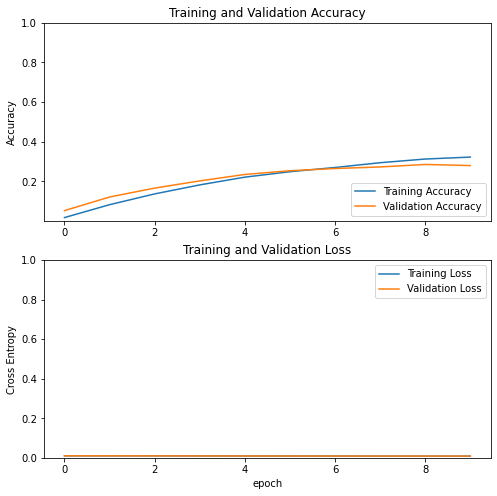

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Model evaluation

In [17]:
model.evaluate(test_set)

52/52 [==============================] - 13s 245ms/step - loss: 0.0101 - accuracy: 0.0121


[0.010098254308104515, 0.012055454775691032]

TODO explain why this is bad

# A better dataset